### Classification Task

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets
from torch.utils.data import SubsetRandomSampler

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


## Dataset

In [2]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transforms.ToTensor())

print(f"Train dataset : {train_dataset}")
print(f"Test dataset  : {test_dataset}")

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
sample_index = 0
num_labels = len(label_names)
image = train_dataset[sample_index][0]
label = label_names[train_dataset[sample_index][1]]

print(f'PyTorch tensor shape: {image.shape}')
print(f'PyTorch tensor type: {image.dtype}')

Train dataset : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test dataset  : Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: classifier_data
    Split: Test
    StandardTransform
Transform: ToTensor()
PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


## Dataloader

In [3]:
# # Define train dataloader
# train_dataloader = DataLoader(train_ds, batch_size=256, shuffle=False) # shuffle=True

# # Define validation dataloader
# validation_dataloader = DataLoader(validation_ds, batch_size=256, shuffle=False) # shuffle=True

# Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #try big bs


# batch_data, batch_labels = next(iter(train_dataloader))
# print(f"TRAIN BATCH SHAPE")
# print(f'Train dataloader size: {len(train_dataloader)} batches')
# print(f"\t Data: {batch_data.shape}")
# print(f"\t Labels: {batch_labels.shape}")

# batch_data, batch_labels = next(iter(validation_dataloader))
# print(f"VALIDATION BATCH SHAPE")
# print(f'Validation dataloader size: {len(validation_dataloader)} batches')
# print(f"\t Data: {batch_data.shape}")
# print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f'Test dataloader size: {len(test_dataloader)} batches')
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TEST BATCH SHAPE
Test dataloader size: 1 batches
	 Data: torch.Size([10000, 1, 28, 28])
	 Labels: torch.Size([10000])


## Convolutional Network

In [4]:
#good convolutinal neural network architecture, 88% accuracy with 150 epochs, v1
class myCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=6, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second convolutional layer
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=12*4*4, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=32, out_features=10),
            nn.ReLU(True),

            # we don't need softmax since we'll use cross entropy loss
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.conv(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.lin(x)
        return x

## Training

In [5]:
# Training function
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    # Set the model to training mode
    model.train()
    # Initialize the loss
    running_loss = 0
    train_loss = []
    # Loop over the training batches
    for (data, label) in tqdm(dataloader):
        # target = onehot encoding of label
        target = torch.eye(10)[label] 
        # Move the input and target data to the selected device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(data)
        assert output.shape == target.shape
        # Compute the loss
        loss = loss_fn(output, target)
        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        #batch loss
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    # Return the average training loss
    train_loss = np.mean(train_loss)
    #print(f"Training loss: {train_loss}")
    return train_loss

#validation function
def validate_epoch(model, dataloader, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the validation loss
    val_loss = []
    # Loop over the validation batches
    with torch.no_grad():
        for (data, label) in dataloader:
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # Compute the output
            output = model(data)
            assert output.shape == target.shape
            # Compute the loss
            loss = loss_fn(output, target)
            #batch loss
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    # Return the average validation loss
    val_loss = np.mean(val_loss)
    #print(f"Validation loss: {val_loss}")
    return val_loss

#reset weights function
def reset_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
            layer.reset_parameters()

# plot and save validation loss
def plot_and_save_losses_and_accuracy(comb_val_losses, model_name):
    fig = plt.figure(figsize=(8,3))
    plt.plot(comb_val_losses, label='Validation loss', color='red')
    plt.ylim(0,2)
    plt.title(f"{model_name} Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    fig.savefig(f"images/{model_name}_val_loss.eps", format="eps", dpi=1000, bbox_inches="tight")
    plt.show()
    plt.close()

#get the percentage of correct predictions on the test set
def get_accuracy(model, test_dataloader, loss_fn, device):
    correct = 0
    total = 0
    model.eval()
    losses = []
    with torch.no_grad():
        for (data, label) in test_dataloader:
            # target = onehot encoding of label
            target = torch.eye(10)[label]
            # Move the input and target data to the selected device
            data, label, target = data.to(device), label.to(device), target.to(device)
            # Compute the output
            output = model(data)
            assert output.shape == target.shape
            # Compute the loss
            losses.append(loss_fn(output, target).detach().cpu().numpy())
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the total number of correct predictions
            correct += pred.eq(label.view_as(pred)).sum().item()
            # Add to the total number of predictions
            total += data.shape[0]
    # Return the accuracy and test loss
    test_loss = np.mean(losses)
    return correct/total, test_loss

## Cross-validation Training and Hyperparameters Tuning

In [6]:
torch.manual_seed(42)
## Parameters
#batch size
batch_sizes = [256, 1024]#[32, 64, 128, 256, 512, 1024]
#learning rate
learning_rates = [5e-4, 1e-3, 5e-3, 1e-2] #[5e-4, 1e-3, 5e-3, 1e-2]
#optimiizer
optimizers = [torch.optim.Adam, torch.optim.SGD] #[torch.optim.Adam, torch.optim.SGD]
optimizer_names = ["Adam", "SGD"]
#epochs
epochs = 2
#k-folds
k_folds = 2

_____________________1/16____________________
Batch size: 256, learning rate: 0.0005, optimizer: Adam


100%|██████████| 235/235 [00:09<00:00, 25.79it/s]


model name: CNN_256_Adam_5.0e-04
Test loss: 0.9429
Test accuracy: 65.2500


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


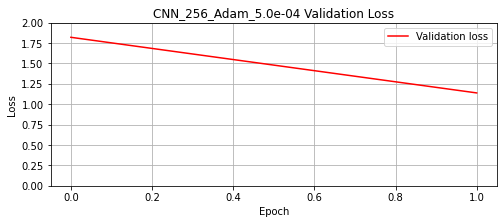

_____________________2/16____________________
Batch size: 256, learning rate: 0.0005, optimizer: SGD


100%|██████████| 235/235 [00:09<00:00, 25.29it/s]


model name: CNN_256_SGD_5.0e-04


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Test loss: 2.3053
Test accuracy: 10.0000


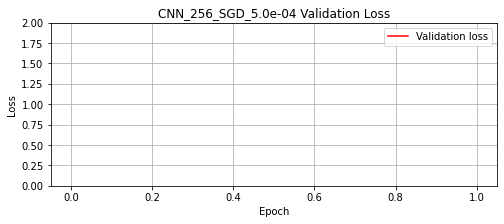

_____________________3/16____________________
Batch size: 256, learning rate: 0.001, optimizer: Adam


100%|██████████| 235/235 [00:10<00:00, 21.94it/s]


model name: CNN_256_Adam_1.0e-03


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Test loss: 0.7552
Test accuracy: 70.0500


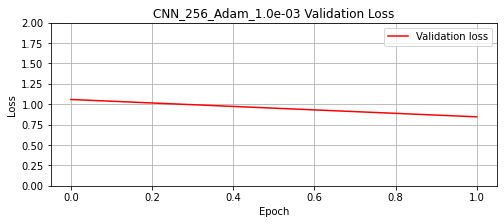

_____________________4/16____________________
Batch size: 256, learning rate: 0.001, optimizer: SGD


 37%|███▋      | 44/118 [00:02<00:04, 15.45it/s]

In [7]:
losses = np.zeros((len(batch_sizes), len(learning_rates), len(optimizers), epochs))
num_tot_combinations = len(batch_sizes) * len(learning_rates) * len(optimizers)
comb = 0
for b, batch_size in enumerate(batch_sizes):
    for l, lr in enumerate(learning_rates):
        for o, (optim, optim_name) in enumerate(zip(optimizers, optimizer_names)):
            print(f"_____________________{comb+1}/{num_tot_combinations}____________________")
            print(f"Batch size: {batch_size}, learning rate: {lr}, optimizer: {optimizer_names[o]}")
            comb += 1
            #create model
            model = myCNN().to(device)
            #create loss function
            loss_fn = nn.CrossEntropyLoss()
            #create optimizer
            optimizer = optim(model.parameters(), lr=lr)
            #K-fold
            kf = KFold(n_splits=k_folds, shuffle=True)
            comb_val_losses = np.zeros(epochs)
            for fold, (train_ids, val_ids) in enumerate(kf.split(train_dataset)):
                #reset weights
                reset_weights(model)
                #create dataloaders
                train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                                        sampler=SubsetRandomSampler(train_ids))
                val_dataloader = DataLoader(train_dataset, batch_size=len(val_ids), #try big bs for val
                                        sampler=SubsetRandomSampler(val_ids))
                #train model
                val_loss_log = []
                for epoch in range(epochs):
                    train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
                    val_loss = validate_epoch(model, val_dataloader, loss_fn, device)
                    val_loss_log.append(val_loss)
                    #print(f"Epoch {epoch+1}/{epochs}: train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
                comb_val_losses += np.array(val_loss_log) / k_folds
            #store losses
            losses[b, l, o, :] = comb_val_losses
            #complete training on the whole dataset
            reset_weights(model)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            for epoch in tqdm(range(epochs)):
                _ = train_epoch(model, train_dataloader, loss_fn, optimizer, device)

            #plot and save losses
            model_name = f"CNN_{batch_size}_{optim_name}_"+'{:.1e}'.format(lr)
            print(f"model name: {model_name}")
            accuracy, test_loss = get_accuracy(model, test_dataloader, loss_fn, device)
            print(f"Test loss: {test_loss:.4f}")
            print(f"Test accuracy: {(accuracy*100):.4f}")
            plot_and_save_losses_and_accuracy(comb_val_losses, model_name)



# Final Training loop

In [ ]:
#set seed
torch.manual_seed(42)

# Instantiate the model
cnn = myCNN().to(device)

# define the loss function
loss_fn = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

In [ ]:
# decide to train or not
load_good_model = False # if True do not train a new model, if False train a new model
good_model_path = "good_models/cnn_v1_epoch_10.pth"

In [ ]:
#create a folder called training to save the model
import pickle
if not load_good_model:
    if not os.path.exists('training'):
        os.makedirs('training')
    #clear the training folder
    if os.listdir('training'):
        for f in os.listdir('training'):
            os.remove(os.path.join('training', f))

# early stopping helper function
def early_stopping(latest_val_losses, best_loss, model, cnt, epoch, increment=0.08, patience=5):
    if epoch < 5:
        return best_loss, cnt, False
    curr_loss = np.mean(latest_val_losses)
    if curr_loss < best_loss:
        best_loss = curr_loss
        #save the model
        torch.save(model.state_dict(), f"training/cnn_epoch_{epoch+1}.pth")
    elif curr_loss > (1+increment)*best_loss:
        cnt += 1
        if cnt >= patience:
            print(f"Early stopping at epoch {epoch}")
            return best_loss, cnt, True
    else:  
        cnt = 0
    return best_loss, cnt, False           

In [ ]:
# training loop
if not load_good_model:
    num_epochs = 5 #150
    train_losses = []
    val_losses = []
    #for early stopping
    early_stopping_cnt = 0
    best_loss = np.inf 
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # Train the model
        train_loss = train_epoch(cnn, train_dataloader, loss_fn, optimizer, device)
        # Validate the model
        val_loss = validate_epoch(cnn, validation_dataloader, loss_fn, device)
        print(f"Validation loss: {val_loss}")
        # Append the losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # early stopping and saving the model
        best_loss, early_stopping_cnt, early_stopping_flag = early_stopping(val_losses, best_loss, cnn, early_stopping_cnt, epoch)
    
    # Save the losses
    with open('training/losses.pkl', 'wb') as f:
        pickle.dump([train_losses, val_losses], f)
else:
    #load the model
    cnn.load_state_dict(torch.load(good_model_path))
    #load the losses
    with open('good_models/losses.pkl', 'rb') as f:
        [train_losses, val_losses] = pickle.load(f)
    #validate the model
    val_loss = validate_epoch(cnn, validation_dataloader, loss_fn, device)
    #test the model
    test_loss = validate_epoch(cnn, test_dataloader, loss_fn, device)

## Losses and model accuracy

In [ ]:
# Plot the training and validation losses
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train_losses, label='Training loss')
ax.plot(val_losses, label='Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = validate_epoch(cnn, test_dataloader, loss_fn, device) 
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {100*get_accuracy(cnn, test_dataloader, device)} %")

## Confusion Matrices

In [ ]:
# function to get all predictions
def get_predictions(model, dataloader, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the predictions
    predictions = []
    # Loop over the test batches
    with torch.no_grad():
        for (data, label) in tqdm(dataloader):
            # Move the input and target data to the selected device
            data, label = data.to(device), label.to(device)
            # Compute the output
            output = model(data)
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the predictions
            predictions.extend(pred.cpu().numpy().tolist())
    return predictions

#get train dataset predictions
train_predictions = get_predictions(cnn, train_dataloader, device)
# get test dataset predictions
test_predictions = get_predictions(cnn, test_dataloader, device)

#get the labels
train_labels = []
for data, label in tqdm(train_dataloader): #note: to have a reasonable cm, dataloader needs to be without shuffle
    train_labels.extend(label.numpy())

test_labels = []
for data, label in tqdm(test_dataloader):
    test_labels.extend(label.numpy())

print(f"Train labels: {train_labels[:10]}")
print(f"Train predictions: {train_predictions[:10]}")
print(f"Test labels: {test_labels[:10]}")
print(f"Test predictions: {test_predictions[:10]}")

# calculate confusion matrix for train and test set 
import sklearn.metrics as metrics
cm_train = metrics.confusion_matrix(train_labels, train_predictions)
cm_test = metrics.confusion_matrix(test_labels, test_predictions)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm_train, target_names=label_names, title='Confusion matrix - Train set')
plot_confusion_matrix(cm_test, target_names=label_names, title='Confusion matrix - Test set')

Apparently, shirts can be confused more easily with t-shirts, coats and pullover. 

## Activations

In [ ]:
## VISUALIZE WEIGHT HISTOGRAMS, ACTIVATION PROFILES, AND RECEPTIVE FIELDS